# Setup

Import necessary modules and do some basic setup.

In [108]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils import *

Define some paths and constants.

In [109]:
# Paths
DATADIR = os.getcwd() + '/../data'

# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'


# Unsupervised learning approaches

## Getting started with the data

In [110]:
#Open data
mslp = xr.open_mfdataset(DATADIR + '/ERA5/Day_era5_2deg_MSL_EU_1979-2021.nc', combine='by_coords')

mslp = mslp.sel(time=slice(DATE_START, DATE_END))

# Convert to hPa
mslp.MSL.values = mslp.MSL.values/100
lon = mslp.lon
lat = mslp.lat
dates = mslp.time


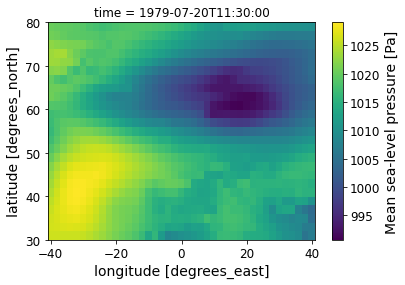

In [111]:
# Plot an example (day) of mslp
mslp.MSL.isel(time=200).plot();

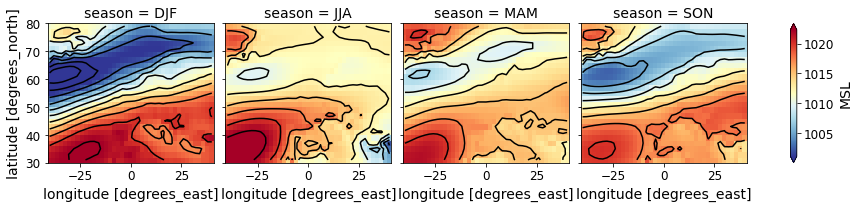

In [112]:
# Process season mean
seas_means = mslp.groupby("time.season").mean()

fg = seas_means.MSL.plot(col="season",  col_wrap=4,
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu_r)

# Use this to plot contours on each panel
# Note that this plotting call uses the original DataArray gradients
fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)

In [113]:
# Compute anomalies
climatology = mslp.mean('time')

# By season
season_climatology = mslp.groupby('time.season').mean('time')

# Climatological anomalies
anom_mslp =  mslp.MSL  - climatology

# By season
anom_seas_mslp = mslp.groupby('time.season') - season_climatology

## PCA

In [141]:
# Start using the whole data set for PCA. Then, anomalies can be used
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# We need to reshape the data [time,latxlon]  
mslp_stacked = mslp.stack(latlon=('lat', 'lon'))

# Load in memory for computing the PCA
mslp_stacked.load()

# Extract msl variable
X = mslp_stacked.MSL

In [142]:
# The number of variables (features) is 1025 (41 points in longitude * 25 points in latitude)
# Standardise the data
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

In [143]:
# Do the PCA
pca = PCA()
pca.fit(X)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

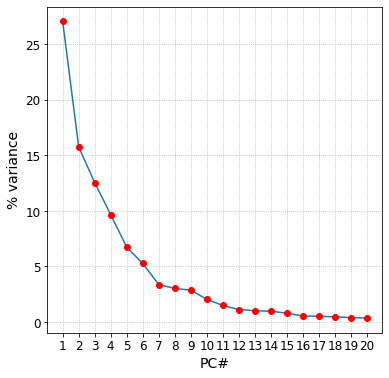

In [144]:
# See how many components 
f, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1,21), pca.explained_variance_ratio_[0:20]*100)
ax.plot(range(1,21), pca.explained_variance_ratio_[0:20]*100,'ro')
ax.grid(ls=':')
ax.set_xticks(range(1,21)); 
ax.set_xlabel('PC#');
ax.set_ylabel("% variance");

In [145]:
# We can take 4 or 5
# Following the literature I will take 4 (e.g. Cortesi et a., 2021)
n = 12 # We can change this number
pca.explained_variance_ratio_[:n].sum()

0.9095372

In [204]:
PCs = pca.fit_transform(X)
PCs_n = PCs[:,:n]

# Data frame format for the selected components
PCdf = pd.DataFrame(PCs_n, index = mslp['time'], \
                    columns = ["PC%s" % (x) for x in range(1, PCs_n.shape[1] +1)])

# See the data
PCdf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
1979-01-01 11:30:00,-16.418085,11.950503,-5.762707,1.175341,-1.295121,-12.934866,10.681583,-3.226187,4.876585,-5.170130,15.477432,-2.655034
1979-01-02 11:30:00,-17.796597,3.597052,-7.132586,4.788782,-11.373435,-9.849724,-0.240520,-7.078946,3.405920,-3.277301,13.131650,-2.296521
1979-01-03 11:30:00,-13.354214,3.901716,-1.463021,0.669005,-8.666795,0.402837,-12.197273,-0.135387,-3.643520,-11.297833,10.841182,-5.282046
1979-01-04 11:30:00,-15.807054,0.808467,-0.970602,-7.491268,1.753537,13.026252,-2.040822,18.791342,-2.844063,-2.369415,5.189134,-8.058639
1979-01-05 11:30:00,3.823341,-9.783282,-8.731400,-14.646765,11.747644,2.965687,-4.057940,23.074621,2.829855,3.896114,7.092285,-7.420454


The EOFS (Empirical orthogonal functions) contain the spatial patterns associated with each PC

In [147]:
EOFs = pca.components_
EOFs = EOFs[:n,:]

# Reshape the data
EOFs_r = EOFs.reshape((n, len(lat), len(lon)))
EOFs_r.shape

(12, 25, 41)

In [148]:
nn = []
tot_var = []
for ip in range(n):
    xn = pca.explained_variance_ratio_[:ip + 1].sum()
    nn.append(xn)
    xx =  pca.explained_variance_ratio_[:ip + 1].sum() - pca.explained_variance_ratio_[:ip ].sum()
    tot_var.append(xx)

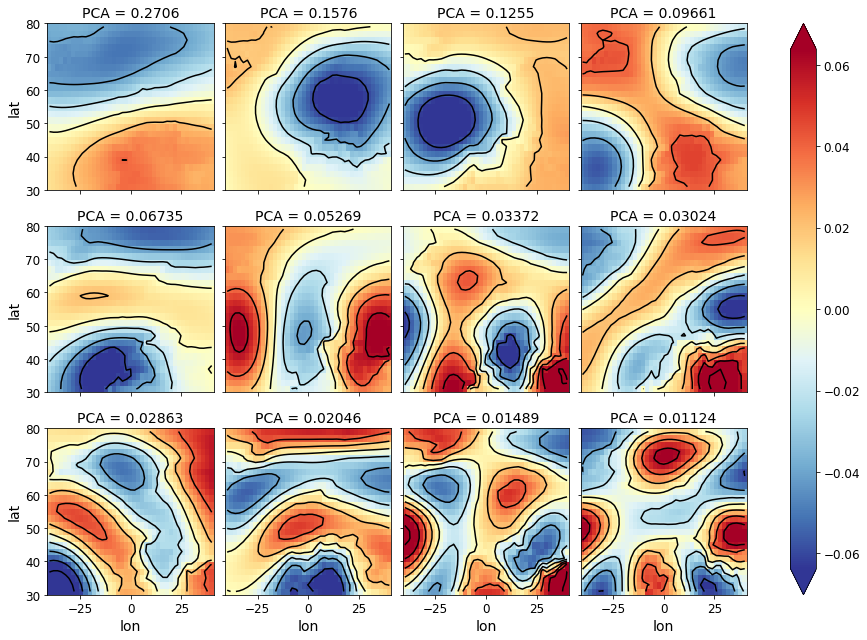

In [149]:
# Convert into Xarray for visualization
XD_EOFs_r = xr.DataArray(data=EOFs_r, coords=[("PCA", tot_var), ("lat", lat.data), ("lon", lon.data)])

fg = XD_EOFs_r.plot(col="PCA",  col_wrap=4,
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu_r)

# Use this to plot contours on each panel
# Note that this plotting call uses the original DataArray gradients
fg.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)

## K-means clustering

In [150]:
from sklearn.cluster import KMeans

# Perform K-cluster analysis using the PCds obtained before
nclusters = 12
kmeans = KMeans(init='k-means++', n_clusters=nclusters, n_init=10)
kmeans.fit(PCdf.values)
y_pred = kmeans.fit_predict(PCdf.values)

# Each day belongs to a cluster, labelled by kmeands.labels_
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [151]:
labels = pd.DataFrame(kmeans.labels_, index=np.array(mslp['time']), columns=['cluster'])

In [152]:
#labels = pd.DataFrame(kmeans.labels_, index=mslp['time'], columns=['cluster'])

# See how many days belong to cluster 0
index = labels.query('cluster == {}'.format(0))
len(index)

1201

For each cluster we calculate the mean 

In [216]:
num_tot = len(labels.cluster)
clusters = []
day_clusters = []
nbdays = []

for iclus in range(nclusters): 
    index = labels.query('cluster == {}'.format(iclus)) 
    freq = (len(index)/num_tot)*100
    freq = round(freq,2)
    nbdays.append(freq)
    cluster = mslp.sel(time=index.index).mean('time')
    Dcluster = mslp.sel(time=index.index)
    clusters.append(cluster)
    day_clusters.append(Dcluster)
    
clusters = xr.concat(clusters, dim='cluster')
clusters.assign_coords(cluster=nbdays)

#day_clusters = xr.concat(day_clusters, dim='cluster')
#day_clusters.assign_coords(day_clusters=nbdays)


<xarray.Dataset>
Dimensions:  (lon: 41, lat: 25, cluster: 12)
Coordinates:
  * lon      (lon) float64 -40.0 -38.0 -36.0 -34.0 -32.0 ... 34.0 36.0 38.0 40.0
  * lat      (lat) float64 31.0 33.0 35.0 37.0 39.0 ... 71.0 73.0 75.0 77.0 79.0
  * cluster  (cluster) float64 7.83 10.32 9.75 6.48 ... 5.89 12.88 15.03 7.63
Data variables:
    MSL      (cluster, lat, lon) float32 1.018e+03 1.018e+03 ... 1.018e+03

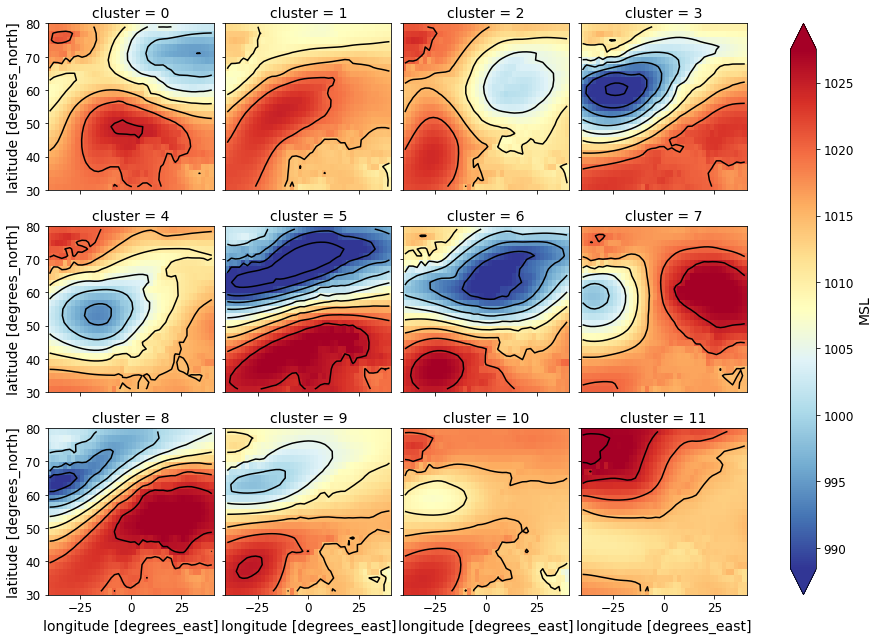

In [217]:
fg_C = clusters.MSL.plot(col="cluster",  col_wrap=4,
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True, 
    cmap=mpl.cm.RdYlBu_r)

fg_C.map_dataarray(
    xr.plot.contour, x="lon", y="lat", colors="k", levels=13, add_colorbar=False
)

In [218]:
# Save PCs and Clusters 
PCdf['date'] = PCdf.index
PCdf.to_csv(DATADIR + 'PCdf.csv',index=False)

In [224]:
def prepare_ClusterData(day_clusters):
    t_list = []
    for iclus in range(0,len(day_clusters)):
        print(iclus)
        tmp = day_clusters[iclus].mean(dim=['lon', 'lat'])
        tmp_df = pd.DataFrame({'date' : tmp['time'], 'MSL': tmp['MSL'], 'Cluster': iclus})
        t_list.append(tmp_df)

    # Merge by date 
    df = pd.concat(t_list)
    df = df.sort_values(by="date")
    return(df)


    

In [225]:
Cluster_spatialmean = prepare_ClusterData(day_clusters)
Cluster_spatialmean

0
1
2
3
4
5
6
7
8
9
10
11


,date,MSL,Cluster
0,1979-01-01 11:30:00,1013.507629,2
0,1979-01-02 11:30:00,1017.233826,10
1,1979-01-03 11:30:00,1016.426819,10
2,1979-01-04 11:30:00,1016.511230,10
0,1979-01-05 11:30:00,1013.134155,1
...,...,...,...
1012,2020-12-27 11:00:00,1011.296692,4
1491,2020-12-28 11:00:00,1011.347839,2
1492,2020-12-29 11:00:00,1010.338440,2
1493,2020-12-30 11:00:00,1012.521118,2


In [226]:
Cluster_spatialmean.to_csv(DATADIR + 'Cluster_spatialmean.csv', index=False)

# Supervised learning approaches

## Data preparation: precipitation time series

**Dataset**: RhiresD, which is a gridded daily precipitation dataset over Switzerland provided by MeteoSwiss. It is based on a spatial interpolation of rain-gauge data. The grid resolution is 1 km, but the effective resolution is in the order of 15-20 km.


**Aggregations levels**: The gridded dataset has been averaged over different regions:
* 12 climatic regions
* 5 aggregated regions
* the whole country

In [ ]:
precip = get_precipitation_data(DATADIR + '/MeteoSwiss/precip_regions.csv', DATE_START, DATE_END)

precip_p95 = precip_exceedance(precip, 0.95)
precip_p99 = precip_exceedance(precip, 0.99)

In [ ]:
variables = read_csv_files(glob.glob(os.path.join(
    DATADIR + '/ERA5/TS_CH/', '*.csv')), DATE_START, DATE_END)

full_data = concat_dataframes([variables, precip.reg_tot])

full_data

## Linear regression for precipitation values

## Logistic regression for extreme events

## Random forest